In [1]:

import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import pandas as pd
from glob import glob
import rioxarray
from scipy.stats import skew
import numpy as np
import seaborn as sns


# Land Cover Dataset

In [2]:
#  Charger les shapefiles Land Cover 
landcover_alg = gpd.read_file("../data/geonetwork_landcover_DZA_gc_adg/dza_gc_adg.shp")
landcover_tun = gpd.read_file("../data/geonetwork_landcover_tun_gc_adg/tun_gc_adg.shp")

print("Land Cover Algeria CRS:", landcover_alg.crs)
print("Land Cover Tunisia CRS:", landcover_tun.crs)

Land Cover Algeria CRS: EPSG:4326
Land Cover Tunisia CRS: EPSG:4326


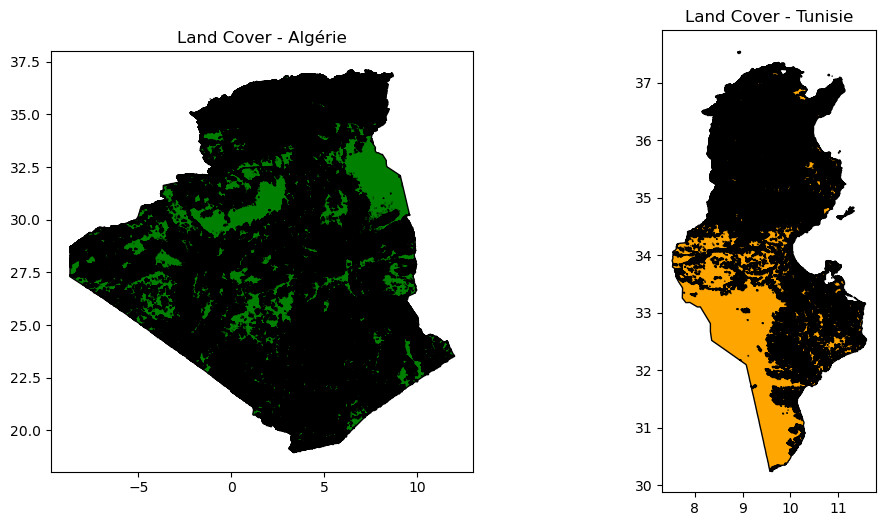

In [3]:
#  Visualiser les Land Cover 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
landcover_alg.plot(ax=ax[0], color='green', edgecolor='black')
ax[0].set_title("Land Cover - Algérie")
landcover_tun.plot(ax=ax[1], color='orange', edgecolor='black')
ax[1].set_title("Land Cover - Tunisie")
plt.show()

# Exploration univariée et bivariée Land Cover Dataset


Résumé statistique des attributs du shapefile :


,ID,GRIDCODE,AREA,LCCCODE,geometry,AREA_M2,LCCCode
count,438513.000000,438513.000000,3.864540e+05,386454,438513,5.205900e+04,52059
unique,NaN,NaN,NaN,22,438513,NaN,20
top,NaN,NaN,NaN,0011,POLYGON ((7.180840924329724 37.079166666715295...,NaN,0003 / 0004
freq,NaN,NaN,NaN,168143,1,NaN,8776
mean,173378.294498,156.209934,5.994332e+06,NaN,NaN,2.981265e+06,NaN
std,117981.553876,65.661496,1.267770e+09,NaN,NaN,2.059695e+08,NaN
min,1.000000,14.000000,1.002582e+05,NaN,NaN,1.002300e+05,NaN
25%,57570.000000,150.000000,1.732502e+05,NaN,NaN,1.580740e+05,NaN
50%,167198.000000,200.000000,3.105674e+05,NaN,NaN,3.091400e+05,NaN
75%,276826.000000,200.000000,6.754102e+05,NaN,NaN,6.892255e+05,NaN



Nombre de valeurs manquantes par colonne :


ID               0
GRIDCODE         0
AREA         52059
LCCCODE      52059
geometry         0
AREA_M2     386454
LCCCode     386454
dtype: int64

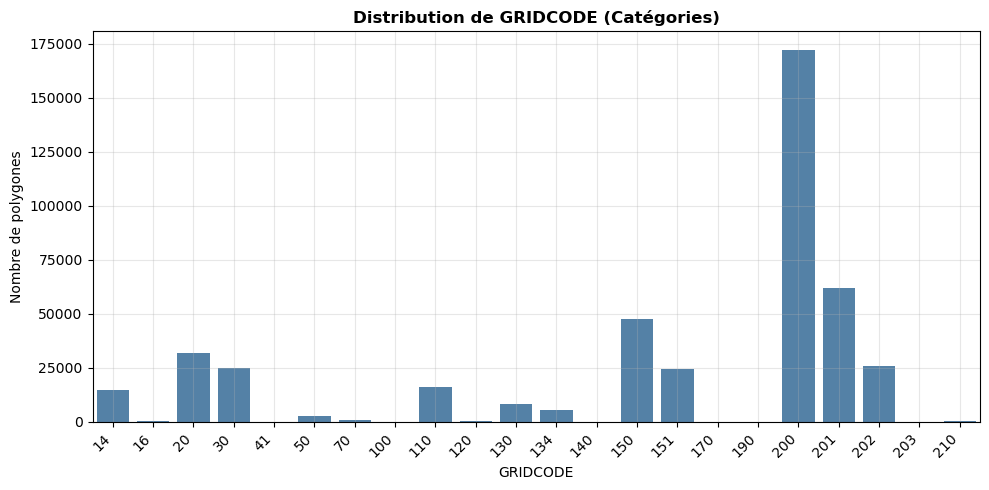

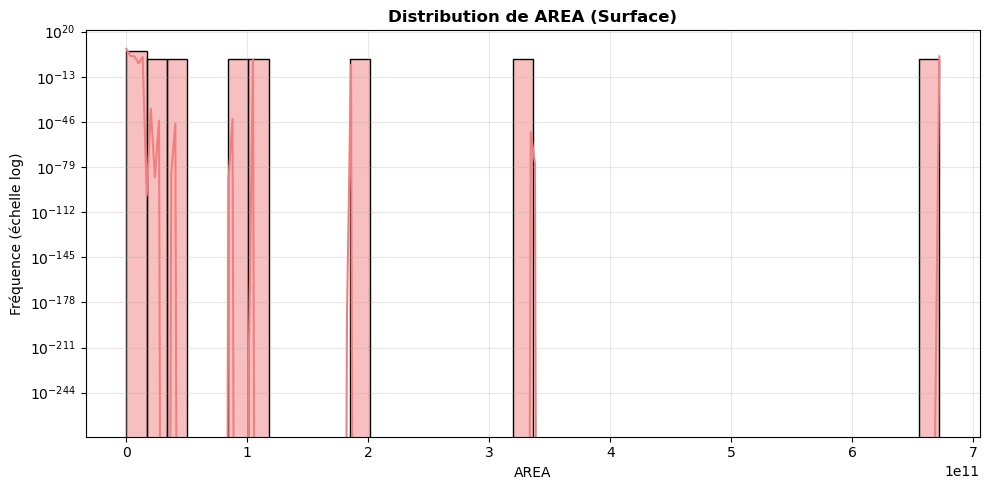

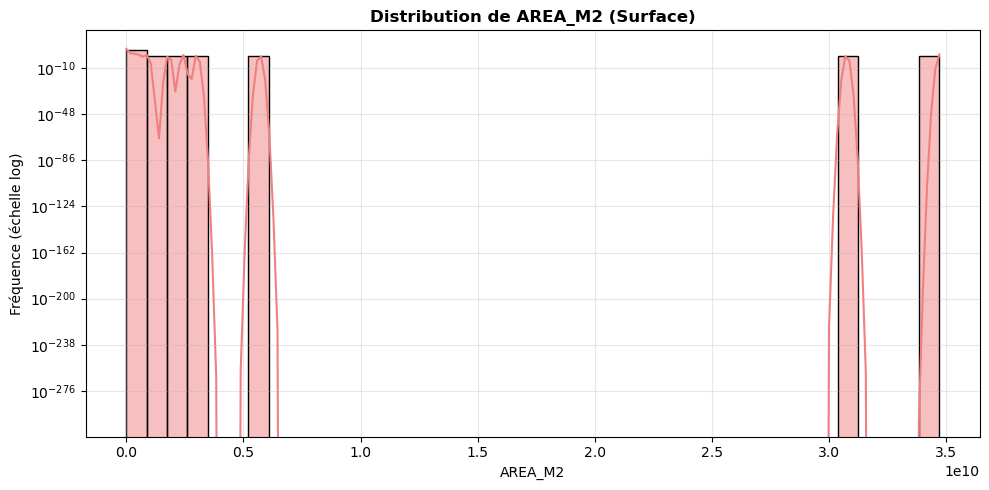

In [4]:

# --- Pour les shapefiles (AVANT dissolve) ---
if 'landcover_alg' in locals() and 'landcover_tun' in locals():
    # Combiner les deux shapefiles SANS dissolve pour garder toutes les lignes
    landcover_combined = pd.concat([landcover_alg, landcover_tun], ignore_index=True)
    
    print("\nRésumé statistique des attributs du shapefile :")
    display(landcover_combined.describe(include='all'))

    print("\nNombre de valeurs manquantes par colonne :")
    display(landcover_combined.isnull().sum())

    # Histogrammes pour les colonnes numériques (en excluant ID uniquement)
    numeric_cols = landcover_combined.select_dtypes(include=[np.number]).columns
    # Exclure uniquement la colonne ID
    numeric_cols = [col for col in numeric_cols if col.upper() != 'ID']
    
    if len(numeric_cols) == 0:
        print("\n Aucune colonne numérique pertinente à afficher")
    
    for col in numeric_cols:
        plt.figure(figsize=(10, 5))
        
        if 'CODE' in col.upper():
            # Pour GRIDCODE et LCCCODE: afficher comme variable discrète/catégorielle
            unique_vals = landcover_combined[col].nunique()
            if unique_vals < 50:  # Si moins de 50 valeurs uniques, utiliser countplot
                sns.countplot(x=landcover_combined[col], color='steelblue', order=sorted(landcover_combined[col].unique()))
                plt.title(f"Distribution de {col} (Catégories)", fontsize=12, fontweight='bold')
                plt.xlabel(col, fontsize=10)
                plt.ylabel("Nombre de polygones", fontsize=10)
                plt.xticks(rotation=45, ha='right')
            else:
                # Si trop de valeurs, utiliser un histogramme
                sns.histplot(landcover_combined[col], kde=False, bins=30, color='steelblue')
                plt.title(f"Distribution de {col}", fontsize=12, fontweight='bold')
                plt.xlabel(col, fontsize=10)
                plt.ylabel("Fréquence", fontsize=10)
        elif 'AREA' in col.upper():
            # Pour toutes les colonnes AREA: histogramme avec échelle log si nécessaire
            data = landcover_combined[col].dropna()
            if len(data) > 0:
                sns.histplot(data, kde=True, bins=40, color='lightcoral')
                plt.title(f"Distribution de {col} (Surface)", fontsize=12, fontweight='bold')
                plt.xlabel(f"{col}", fontsize=10)
                plt.ylabel("Fréquence", fontsize=10)
                # Ajouter une échelle log en y si les données sont très dispersées
                if data.max() / data.min() > 1000:
                    plt.yscale('log')
                    plt.ylabel("Fréquence (échelle log)", fontsize=10)
        else:
            # Pour les autres colonnes numériques
            sns.histplot(landcover_combined[col], kde=True, bins=30, color='skyblue')
            plt.title(f"Distribution de {col}", fontsize=12, fontweight='bold')
            plt.xlabel(col, fontsize=10)
            plt.ylabel("Fréquence", fontsize=10)
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()





 Distribution de LCCCODE (Land Cover Classification Code)

Nombre de catégories LCCCODE : 22

Top 10 catégories :


LCCCODE
0011                             168143
6001                              57050
20049 // 20058                    39532
6004                              25243
0003 / 0004                       23115
0004 // 0003                      18023
20058                             15922
21446 // 21450-121340 / 21454     11903
11498                             11155
21450                              7313
Name: count, dtype: int64

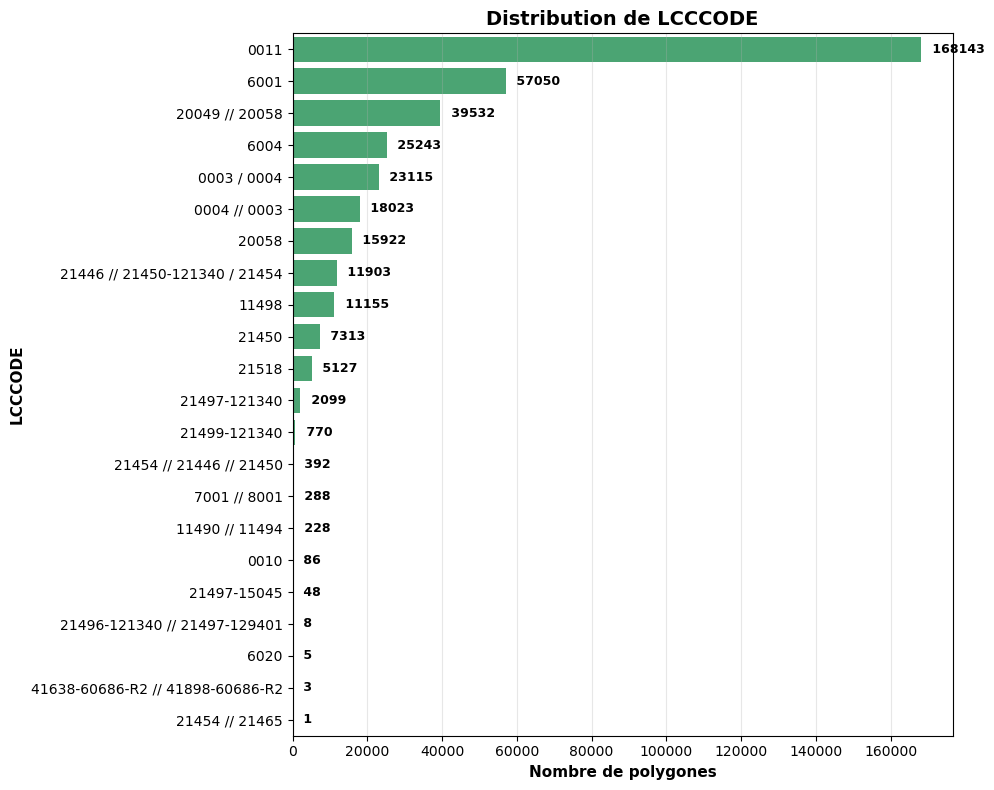

In [5]:
# === Distribution de LCCCODE ===
if 'landcover_alg' in locals() and 'landcover_tun' in locals():
    landcover_combined = pd.concat([landcover_alg, landcover_tun], ignore_index=True)
    
    # Vérifier si LCCCODE existe
    if 'LCCCODE' in landcover_combined.columns:
        print("\n Distribution de LCCCODE (Land Cover Classification Code)")
        
        # Compter les valeurs
        value_counts = landcover_combined['LCCCODE'].value_counts()
        print(f"\nNombre de catégories LCCCODE : {len(value_counts)}")
        print("\nTop 10 catégories :")
        display(value_counts.head(10))
        
        # Graphique vertical (barres horizontales)
        plt.figure(figsize=(10, max(8, len(value_counts) * 0.3)))
        
        # Limiter au top 30 si trop de catégories
        if len(value_counts) > 30:
            plot_data = value_counts.head(30)
            title_suffix = " (Top 30 catégories)"
        else:
            plot_data = value_counts
            title_suffix = ""
        
        # Créer le barplot
        ax = sns.barplot(x=plot_data.values, y=plot_data.index, color='mediumseagreen')
        plt.title(f"Distribution de LCCCODE{title_suffix}", fontsize=14, fontweight='bold')
        plt.xlabel("Nombre de polygones", fontsize=11, fontweight='bold')
        plt.ylabel("LCCCODE", fontsize=11, fontweight='bold')
        
        # Ajouter les valeurs sur les barres
        for i, v in enumerate(plot_data.values):
            ax.text(v + max(plot_data.values) * 0.01, i, f' {v}', 
                   va='center', fontsize=9, fontweight='bold')
        
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
    else:
        print(" Colonne LCCCODE non trouvée dans les données")

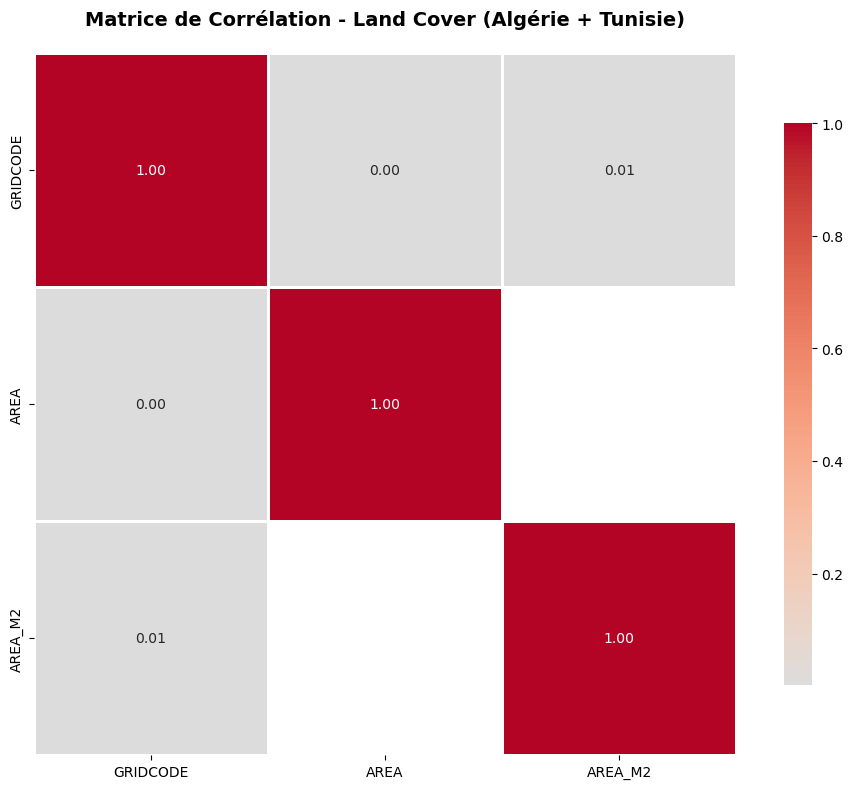

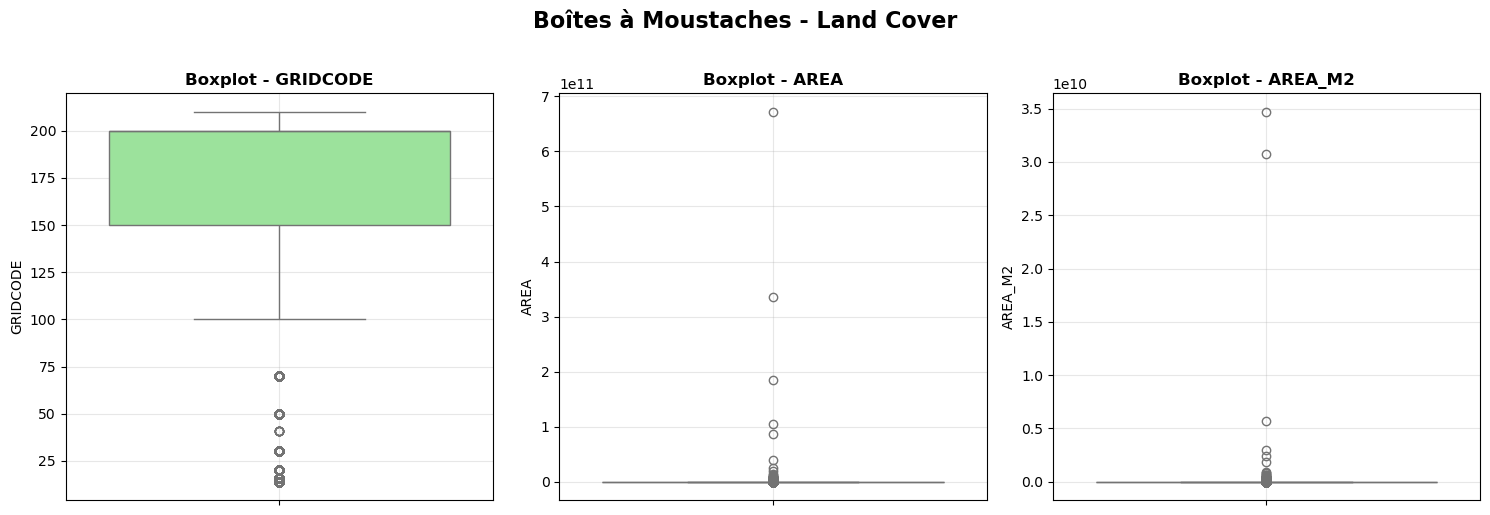

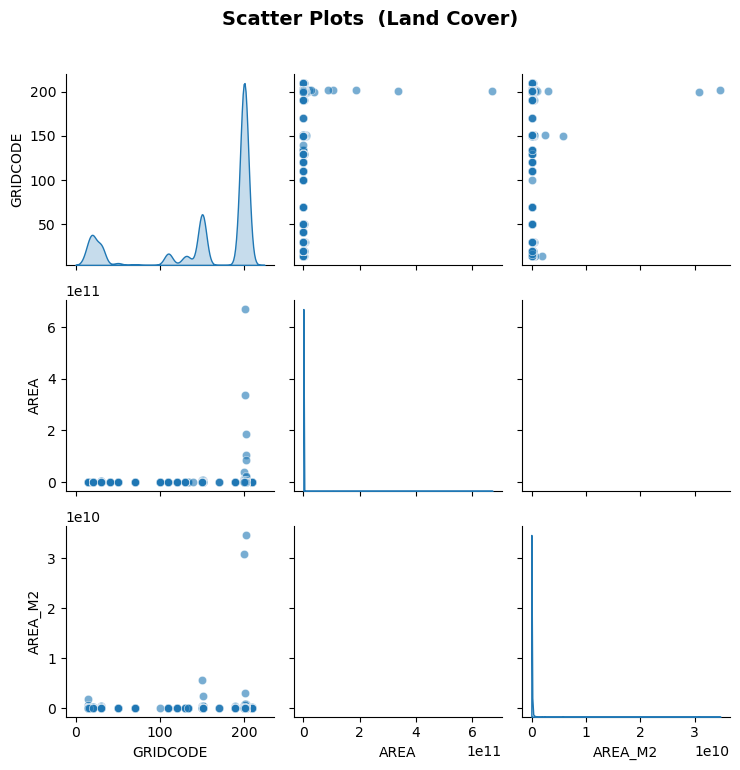

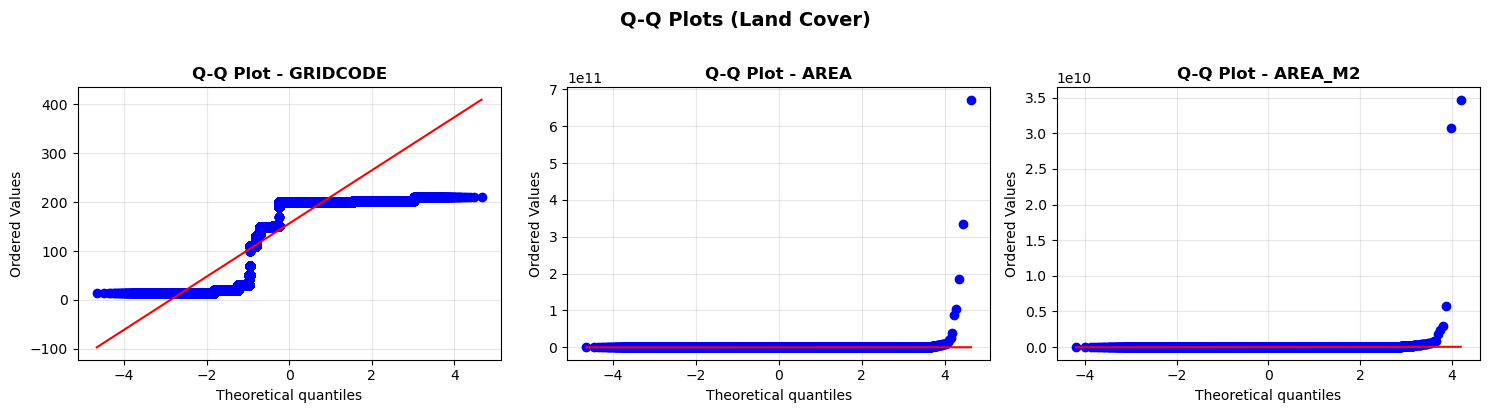

In [6]:
from scipy import stats

if 'landcover_alg' in locals() and 'landcover_tun' in locals():
    
    # Combiner les données numériques des deux pays
    landcover_combined = pd.concat([landcover_alg, landcover_tun], ignore_index=True)
    
    # Sélectionner uniquement les colonnes numériques (sans ID)
    numeric_data = landcover_combined.select_dtypes(include=[np.number])
    if 'ID' in numeric_data.columns:
        numeric_data = numeric_data.drop(columns=['ID'])
    
    if numeric_data.shape[1] > 1:
        # Calculer la matrice de corrélation
        correlation_matrix = numeric_data.corr()
        
        # 1. Matrice de corrélation 
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                    center=0, square=True, linewidths=1, 
                    cbar_kws={"shrink": 0.8}, fmt='.2f')
        plt.title("Matrice de Corrélation - Land Cover (Algérie + Tunisie)", 
                  fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        # 2. Boxplots pour chaque variable numérique
        n_cols = len(numeric_data.columns)
        fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))
        if n_cols == 1:
            axes = [axes]
        
        for idx, col in enumerate(numeric_data.columns):
            sns.boxplot(y=numeric_data[col], ax=axes[idx], color='lightgreen')
            axes[idx].set_title(f"Boxplot - {col}", fontweight='bold')
            axes[idx].set_ylabel(col)
            axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle("Boîtes à Moustaches - Land Cover", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # 3. Scatter plots 
        if n_cols > 1:
            sns.pairplot(numeric_data, diag_kind='kde', plot_kws={'alpha': 0.6})
            plt.suptitle("Scatter Plots  (Land Cover)", 
                        fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.show()
        
        # 4. Q-Q Plots 
        n_vars = len(numeric_data.columns)
        fig, axes = plt.subplots(1, n_vars, figsize=(5*n_vars, 4))
        if n_vars == 1:
            axes = [axes]
        
        for idx, col in enumerate(numeric_data.columns):
            stats.probplot(numeric_data[col].dropna(), dist="norm", plot=axes[idx])
            axes[idx].set_title(f"Q-Q Plot - {col}", fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle("Q-Q Plots (Land Cover)", 
                    fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print(" Pas assez de colonnes numériques ")


## pretraitement 

###  AFFICHAGE POUR IDENTIFIER LE NOM INTRUS


In [7]:

landcover_alg.columns = landcover_alg.columns.str.strip()
landcover_tun.columns = landcover_tun.columns.str.strip()
 
print("\nColonnes Algérie :", landcover_alg.columns.tolist())
print("Colonnes Tunisie :", landcover_tun.columns.tolist())



Colonnes Algérie : ['ID', 'GRIDCODE', 'AREA', 'LCCCODE', 'geometry']
Colonnes Tunisie : ['AREA_M2', 'ID', 'GRIDCODE', 'LCCCode', 'geometry']


### Standardisation des Superficies

In [8]:

landcover_alg.rename(columns={'AREA': 'area_sqm'}, inplace=True)
# S'assurer que les noms de colonnes sont propres
landcover_alg.columns = landcover_alg.columns.str.strip()

# 2. Renommer 'AREA_M2' (Tunisie) pour correspondre
landcover_tun.rename(columns={'AREA_M2': 'area_sqm'}, inplace=True)
# S'assurer que les noms de colonnes sont propres
landcover_tun.columns = landcover_tun.columns.str.strip()

print("Colonnes de Superficie unifiées en 'area_sqm'.")

Colonnes de Superficie unifiées en 'area_sqm'.


### Standardisation des LCCCode

In [9]:

# Renommer LCCCODE (Algérie) en minuscule
try:
    landcover_alg.rename(columns={'LCCCODE': 'lcc_code'}, inplace=True)
except KeyError:
    # Si la colonne n'est pas LCCCODE, elle est peut-être déjà en minuscule
    pass

# Renommer LCCCode (Tunisie) pour standardiser
try:
    landcover_tun.rename(columns={'LCCCode': 'lcc_code'}, inplace=True)
except KeyError:
    pass

print("Colonnes de Codes de Classification unifiées en 'lcc_code'.")

Colonnes de Codes de Classification unifiées en 'lcc_code'.


### Fusion

In [10]:

# Ajout d'une colonne pour identifier l'origine (bonne pratique)
landcover_alg['pays'] = 'Algérie'
landcover_tun['pays'] = 'Tunisie'

# Fusion des deux GeoDataFrames
landcover_total = pd.concat([landcover_alg, landcover_tun], ignore_index=True)

print("\n--- Fusion effectuée ---")
print(f"Total des lignes : {landcover_total.shape[0]}")
print(landcover_total.head())


--- Fusion effectuée ---
Total des lignes : 438513
   ID  GRIDCODE      area_sqm      lcc_code  \
0   4       210  6.228187e+06  7001 // 8001   
1   2       210  6.242408e+06  7001 // 8001   
2   1       210  1.482995e+06  7001 // 8001   
3   8        50  4.590841e+08  21497-121340   
4  13       210  6.371533e+06  7001 // 8001   

                                            geometry     pays  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...  Algérie  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...  Algérie  
2  POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7...  Algérie  
3  POLYGON ((6.12361 36.68472, 6.12361 36.69306, ...  Algérie  
4  POLYGON ((6.26181 37.02361, 6.26193 37.02514, ...  Algérie  


In [11]:
print("\n--- 1. Traitement de la Colonne CATÉGORIELLE : LCCCode ---")
col_cat = 'lcc_code'

nan_count_cat = landcover_total[col_cat].isnull().sum()
total_rows_cat = len(landcover_total)
nan_percentage_cat = (nan_count_cat / total_rows_cat) * 100

print(f"Colonne : {col_cat} | NaNs : {nan_count_cat} ({nan_percentage_cat:.2f} %)")

# Imputation par le Mode pour une colonne catégorielle avec beaucoup de NaNs
if nan_percentage_cat > 0:
    # Calcul du Mode (valeur la plus fréquente)
    mode_val = landcover_total[col_cat].mode()[0]
    
    # Imputation par le Mode (méthode d'assignation sécurisée)
    landcover_total[col_cat] = landcover_total[col_cat].fillna(mode_val)
    
    print(f"  → Imputation par le MODE ({mode_val}) effectuée pour les {nan_count_cat} NaNs.")
else:
    print("  → 0% de NaNs. Aucune action requise.")


--- 1. Traitement de la Colonne CATÉGORIELLE : LCCCode ---
Colonne : lcc_code | NaNs : 0 (0.00 %)
  → 0% de NaNs. Aucune action requise.


In [12]:

# 1. Sélectionner les colonnes numériques à analyser
cols_to_check = ['area_sqm','geometry','GRIDCODE']
df = landcover_total.copy() # On travaille sur le DataFrame fusionné

print("\n--- Analyse et Traitement des Valeurs Manquantes sur l'Ensemble des Données ---")

for col in cols_to_check:
    
    # Calcul des métriques
    nan_count = df[col].isnull().sum()
    total_rows = len(df)
    nan_percentage = (nan_count / total_rows) * 100
    
    # Affichage du statut
    print(f"\nColonne : {col} | NaNs : {nan_count} ({nan_percentage:.2f} %)")

    
    # CAS 1 : Moins de 5% de NaNs (Seuil = 5%)
    if 0 < nan_percentage < 5:
        print(f"  → Moins de 5% de NaNs. Suppression des {nan_count} lignes.")
        # Utiliser dropna sur le DataFrame fusionné
        landcover_total.dropna(subset=[col], inplace=True)
        
    # CAS 2 : 5% ou plus de NaNs
    elif nan_percentage >= 5:
        
        # Calcul de la Skewness (symétrie) sur les valeurs existantes
        skewness = landcover_total[col].dropna().skew()
        
        print(f"  → {nan_percentage:.2f} % de NaNs (>= 5%). Imputation nécessaire.")
        print(f"  → Skewness (symétrie) : {skewness:.2f}")

        # Si la distribution est fortement asymétrique (|skew| >= 0.5)
        if abs(skewness) >= 0.5:
            # Imputation par la Médiane
            median_val = landcover_total[col].median()
            landcover_total[col].fillna(median_val, inplace=True)
            print(f"  → Distribution asymétrique : Imputation par la MÉDIANE ({median_val:.2f}).")
        
        # Sinon (distribution symétrique)
        else:
            # Imputation par la Moyenne
            mean_val = landcover_total[col].mean()
            landcover_total[col].fillna(mean_val, inplace=True)
            print(f"  → Distribution symétrique : Imputation par la MOYENNE ({mean_val:.2f}).")
            
    # CAS 3 : Aucune valeur manquante
    else: # nan_percentage == 0
        print(f"  → 0% de NaNs. Aucune action requise.")


--- Analyse et Traitement des Valeurs Manquantes sur l'Ensemble des Données ---

Colonne : area_sqm | NaNs : 0 (0.00 %)
  → 0% de NaNs. Aucune action requise.

Colonne : geometry | NaNs : 0 (0.00 %)
  → 0% de NaNs. Aucune action requise.

Colonne : GRIDCODE | NaNs : 0 (0.00 %)
  → 0% de NaNs. Aucune action requise.


### Supression des doublons

In [13]:
avant = len(landcover_total)
landcover_total = landcover_total.drop_duplicates()
suppr = avant - len(landcover_total)
print(f"Doublons supprimés : {suppr}")


Doublons supprimés : 0


### Correction geometrique

In [14]:

# 1. Vérifier combien de géométries sont invalides
invalid_mask = ~landcover_total.is_valid
invalid_count = invalid_mask.sum()
print(f"Nombre de géométries invalides avant correction : {invalid_count}")

# 2. Corriger les géométries invalides
if invalid_count > 0:
    landcover_total.loc[invalid_mask, 'geometry'] = \
        landcover_total.loc[invalid_mask, 'geometry'].buffer(0)
    
    # Mettre à jour le masque après buffer(0)
    invalid_mask_after_buffer = ~landcover_total.is_valid
    
    # Étape 2 : Utiliser make_valid() pour les cas restants
    landcover_total.loc[invalid_mask_after_buffer, 'geometry'] = \
        landcover_total.loc[invalid_mask_after_buffer, 'geometry'].make_valid()
    
    print(" Géométries invalides corrigées avec succès.")
else:
    print(" Toutes les géométries sont déjà valides.")

# 3. Vérifier à nouveau après correction
invalid_count_after = (~landcover_total.is_valid).sum()
print(f"Nombre de géométries invalides après correction : {invalid_count_after}")

if invalid_count_after == 0:
    print(" Le prétraitement géométrique est parfait.")

Nombre de géométries invalides avant correction : 8932
 Géométries invalides corrigées avec succès.
Nombre de géométries invalides après correction : 0
 Le prétraitement géométrique est parfait.


### Log

In [15]:
# Créer une nouvelle colonne transformée (Log base e)
landcover_total['log_area_sqm'] = np.log1p(landcover_total['area_sqm'])

### IQR

In [20]:
# Calculer le 1er quartile (Q1) et le 3ème quartile (Q3)
Q1 = landcover_total['log_area_sqm'].quantile(0.25)
Q3 = landcover_total['log_area_sqm'].quantile(0.75)
IQR = Q3 - Q1

# Définir les limites des outliers (1.5 * IQR est la norme pour les boxplots)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

landcover_total['log_area_sqm'] = np.where(landcover_total['log_area_sqm'] > upper_bound, upper_bound, landcover_total['log_area_sqm'])
landcover_total['log_area_sqm'] = np.where(landcover_total['log_area_sqm'] < lower_bound, lower_bound, landcover_total['log_area_sqm'])


Matrice de Corrélation Finale (log_area_sqm vs GRIDCODE) :
              log_area_sqm  GRIDCODE
log_area_sqm      1.000000  0.030055
GRIDCODE          0.030055  1.000000


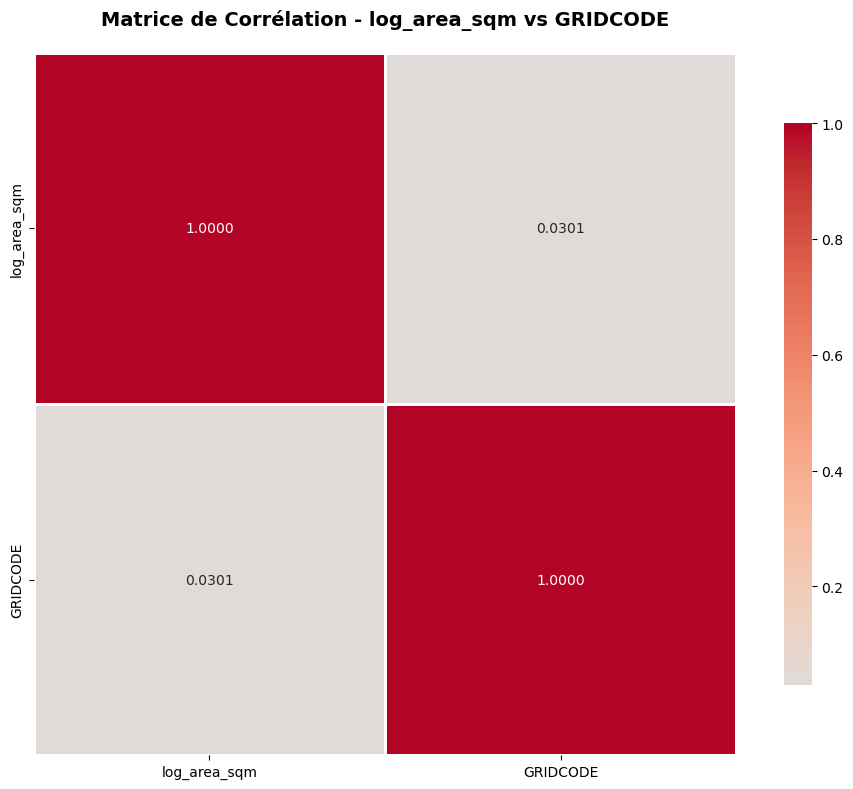

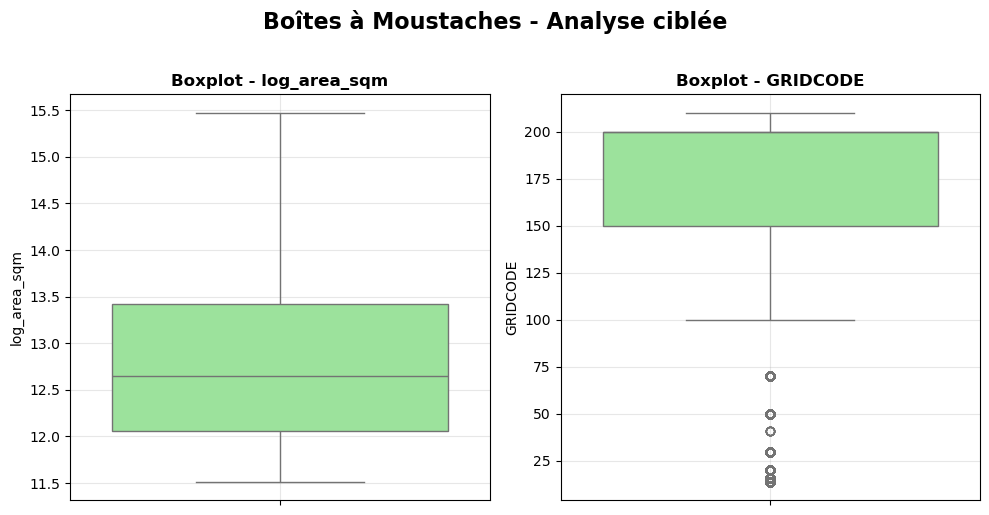

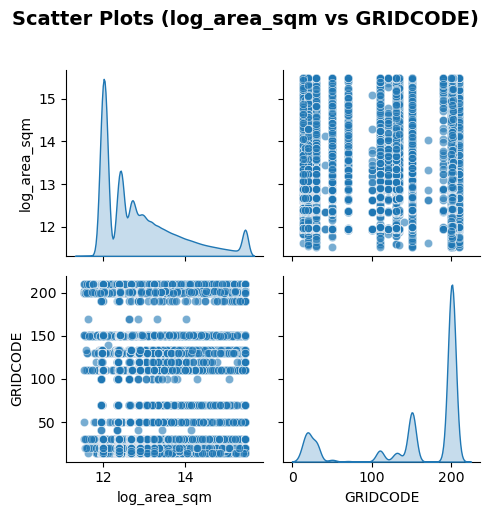

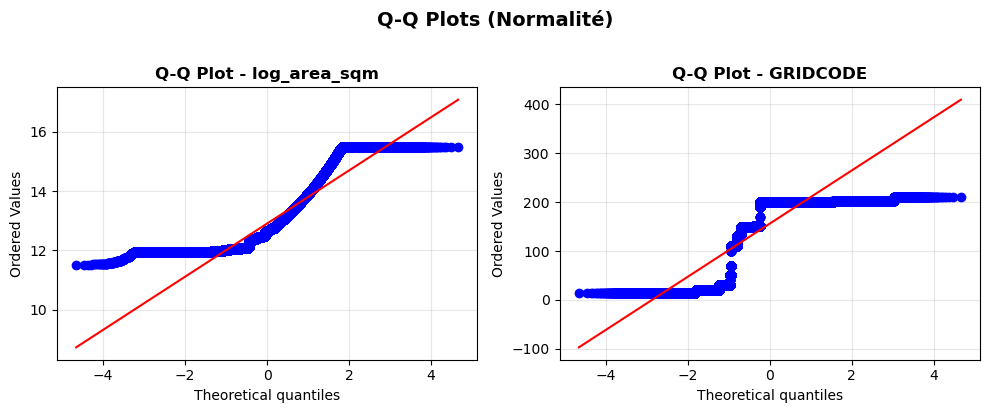

In [21]:
# Assurez-vous que landcover_total existe et contient les colonnes nécessaires
if 'landcover_total' in locals():
    
    # 1. DÉFINITION EXPLICITE : Ne sélectionner que les deux colonnes souhaitées
    cols_for_analysis = ['log_area_sqm', 'GRIDCODE']
    
    # Utiliser .copy() est une bonne pratique pour éviter les SettingWithCopyWarning
    # même si dans ce cas, c'est pour l'analyse et non la modification.
    numeric_data = landcover_total[cols_for_analysis].copy()
    
    # Le reste du code utilise maintenant uniquement ces deux colonnes :
    n_cols = numeric_data.shape[1]
    
    if n_cols > 1:
        # Calculer la matrice de corrélation (Pearson, car les données sont nettoyées)
        correlation_matrix = numeric_data.corr(method='pearson')
        
        print("\nMatrice de Corrélation Finale (log_area_sqm vs GRIDCODE) :")
        print(correlation_matrix)
        
        # 1. Matrice de corrélation (Heatmap)
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                    center=0, square=True, linewidths=1, 
                    cbar_kws={"shrink": 0.8}, fmt='.4f') # fmt='.4f' pour plus de précision
        plt.title("Matrice de Corrélation - log_area_sqm vs GRIDCODE", 
                      fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        # 2. Boxplots pour chaque variable
        n_cols = numeric_data.shape[1]
        fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))
        if n_cols == 1:
            axes = [axes]
        
        for idx, col in enumerate(numeric_data.columns):
            sns.boxplot(y=numeric_data[col], ax=axes[idx], color='lightgreen')
            axes[idx].set_title(f"Boxplot - {col}", fontweight='bold')
            axes[idx].set_ylabel(col)
            axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle("Boîtes à Moustaches - Analyse ciblée", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

        
        # 3. Scatter plots (PairPlot)
        if n_cols > 1:
            # Pour 2 colonnes, PairPlot affiche le scatter et la distribution (KDE)
            sns.pairplot(numeric_data, diag_kind='kde', plot_kws={'alpha': 0.6})
            plt.suptitle("Scatter Plots (log_area_sqm vs GRIDCODE)", 
                          fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.show()
        
        # 4. Q-Q Plots 
        n_vars = len(numeric_data.columns)
        fig, axes = plt.subplots(1, n_vars, figsize=(5*n_vars, 4))
        if n_vars == 1:
            axes = [axes]
        
        for idx, col in enumerate(numeric_data.columns):
            stats.probplot(numeric_data[col].dropna(), dist="norm", plot=axes[idx])
            axes[idx].set_title(f"Q-Q Plot - {col}", fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle("Q-Q Plots (Normalité)", 
                      fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print(" Pas assez de colonnes pour l'analyse (moins de deux).")


---  Analyse Statistique Finale (landcover_total) ---

Résumé statistique :


,log_area_sqm,GRIDCODE,pays
count,438513.000000,438513.000000,438513
unique,NaN,NaN,2
top,NaN,NaN,Algérie
freq,NaN,NaN,386454
mean,12.903332,156.209934,NaN
std,0.966022,65.661496,NaN
min,11.515233,14.000000,NaN
25%,12.059688,150.000000,NaN
50%,12.644984,200.000000,NaN
75%,13.424520,200.000000,NaN



Vérification finale des valeurs manquantes (Clés) :


log_area_sqm    0
GRIDCODE        0
lcc_code        0
dtype: int64


---  Visualisations des Variables Clés ---


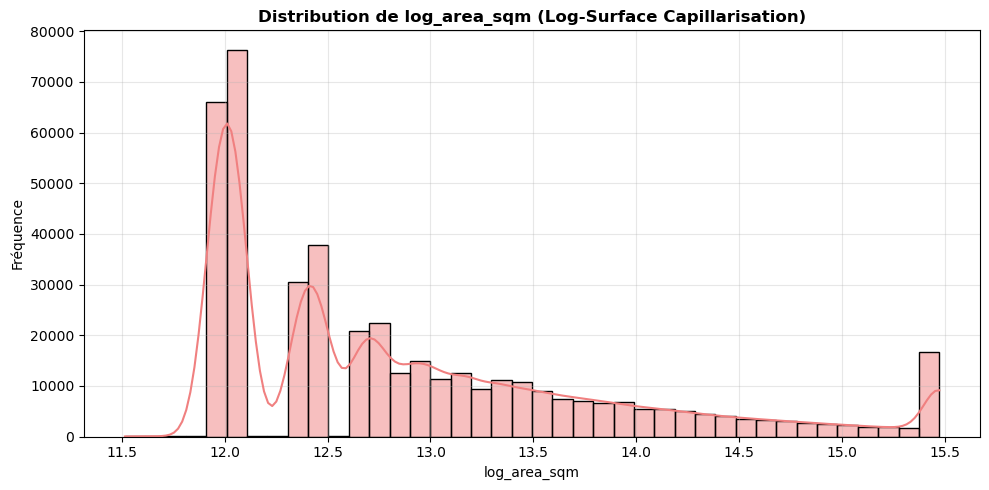

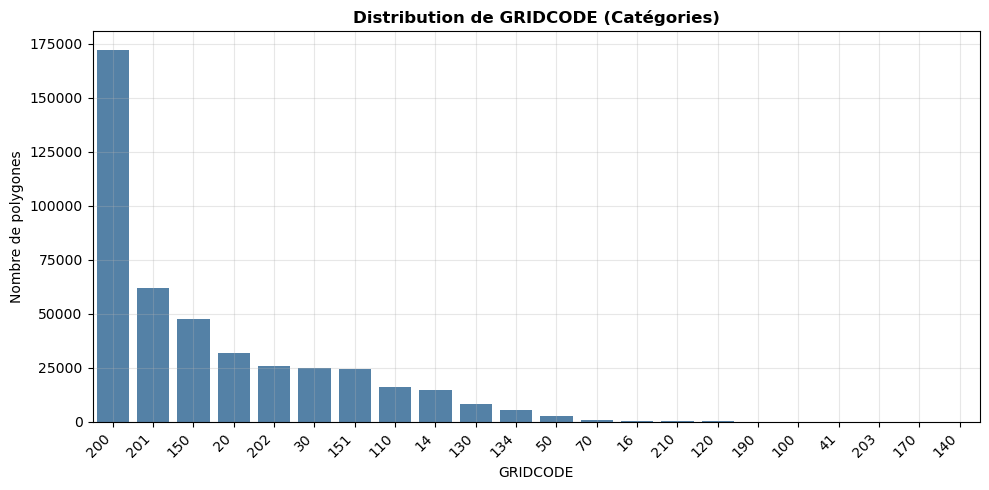

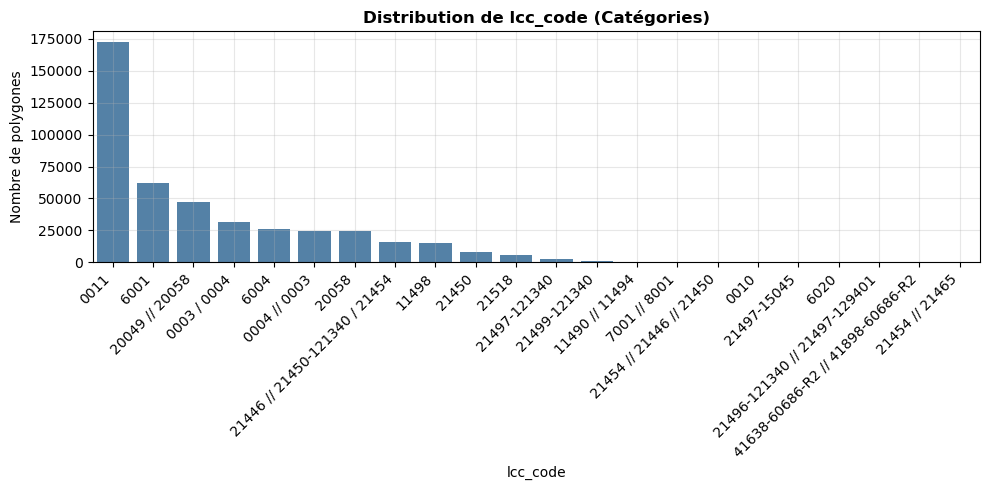

In [22]:

if 'landcover_total' in locals():
    
    print("\n---  Analyse Statistique Finale (landcover_total) ---")
    
    # 1. Résumé statistique (inclut log_area_sqm et GRIDCODE)
    print("\nRésumé statistique :")
    # Afficher uniquement les colonnes numériques clés pour la clarté
    display(landcover_total[['log_area_sqm', 'GRIDCODE', 'pays']].describe(include='all'))

    # 2. Vérification finale des NaNs (devrait être 0 pour les colonnes prétraitées)
    print("\nVérification finale des valeurs manquantes (Clés) :")
    nan_check = landcover_total[['log_area_sqm', 'GRIDCODE', 'lcc_code']].isnull().sum()
    display(nan_check)
    
    # Définition des colonnes à visualiser
    cols_to_plot = ['log_area_sqm', 'GRIDCODE', 'lcc_code']
    
    print("\n---  Visualisations des Variables Clés ---")

    for col in cols_to_plot:
        plt.figure(figsize=(10, 5))
        
        # --- Cas 1 : Variables catégorielles (GRIDCODE, lcc_code) ---
        if 'CODE' in col.upper():
            # Conversion en type catégoriel pour un meilleur affichage des codes
            data = landcover_total[col].astype('category').dropna()
            
            if data.nunique() < 50:
                # Utiliser countplot pour les catégories
                sns.countplot(x=data, color='steelblue', 
                              order=data.value_counts().index)
                plt.title(f"Distribution de {col} (Catégories)", fontsize=12, fontweight='bold')
                plt.xlabel(col, fontsize=10)
                plt.ylabel("Nombre de polygones", fontsize=10)
                plt.xticks(rotation=45, ha='right')
            else:
                # Utiliser histplot si trop de catégories (utile pour GRIDCODE si peu de NaNs)
                sns.histplot(data.cat.codes, kde=False, bins=30, color='steelblue')
                plt.title(f"Distribution de {col} (Fréquence des Codes)", fontsize=12, fontweight='bold')
                plt.xlabel(col, fontsize=10)
                plt.ylabel("Fréquence", fontsize=10)
        
        # --- Cas 2 : Variables Numériques (log_area_sqm) ---
        elif 'AREA' in col.upper():
            data = landcover_total[col].dropna()
            
            # Utilisation de histplot sur la version log-transformée (qui est censée être plus normale)
            sns.histplot(data, kde=True, bins=40, color='lightcoral')
            plt.title(f"Distribution de {col} (Log-Surface Capillarisation)", fontsize=12, fontweight='bold')
            plt.xlabel(f"{col}", fontsize=10)
            plt.ylabel("Fréquence", fontsize=10)
            
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

else:
    print("Le DataFrame 'landcover_total' n'est pas défini. Veuillez exécuter les étapes de fusion.")

# Sauvgarde

In [23]:
# Sauvegarder le GeoDataFrame nettoyé dans un fichier GeoPackage
output_path = "../data/landcover_total_clean.gpkg"

# Convertir explicitement en GeoDataFrame si nécessaire
if not isinstance(landcover_total, gpd.GeoDataFrame):
    landcover_total = gpd.GeoDataFrame(landcover_total, geometry='geometry')

# Sauvegarder
landcover_total.to_file(output_path, driver="GPKG")


# Encodage des Variables Catégorielles

In [11]:
import geopandas as gpd

file_path = "../data/landcover_total_clean.gpkg"

df_final_clean = gpd.read_file(file_path)

print(f"Jeu de données rechargé dans la variable 'df_final_clean' avec {df_final_clean.shape[0]} lignes.")

Jeu de données rechargé dans la variable 'df_final_clean' avec 438513 lignes.


## Analyse de la Distribution de lcc_code

## Label Encoding de lcc_code

- 22 catégories uniques (One-Hot créerait 22 colonnes)


In [12]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Créer une copie de sauvegarde de la colonne originale
df_final_clean['lcc_code_original'] = df_final_clean['lcc_code'].copy()

# Initialiser le LabelEncoder
label_encoder = LabelEncoder()

# Appliquer le Label Encoding
df_final_clean['lcc_code_encoded'] = label_encoder.fit_transform(df_final_clean['lcc_code'])

# Créer un dictionnaire de mapping pour la traçabilité
mapping_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("=== Label Encoding appliqué avec succès ===\n")
print(f"Nombre de catégories encodées : {len(mapping_dict)}")
print("\n=== Dictionnaire de Mapping (lcc_code → code numérique) ===\n")

# Afficher le mapping sous forme de DataFrame pour plus de clarté
mapping_df = pd.DataFrame(list(mapping_dict.items()), columns=['lcc_code_original', 'code_encoded'])
mapping_df = mapping_df.sort_values('code_encoded')
display(mapping_df)

print("\n=== Vérification des premières lignes après encodage ===\n")
display(df_final_clean[['lcc_code_original', 'lcc_code_encoded']].head(20))

=== Label Encoding appliqué avec succès ===

Nombre de catégories encodées : 22

=== Dictionnaire de Mapping (lcc_code → code numérique) ===



,lcc_code_original,code_encoded
0,0003 / 0004,0
1,0004 // 0003,1
2,0010,2
3,0011,3
4,11490 // 11494,4
5,11498,5
6,20049 // 20058,6
7,20058,7
8,21446 // 21450-121340 / 21454,8
9,21450,9



=== Vérification des premières lignes après encodage ===



,lcc_code_original,lcc_code_encoded
0,7001 // 8001,21
1,7001 // 8001,21
2,7001 // 8001,21
3,21497-121340,13
4,7001 // 8001,21
5,21497-121340,13
6,21450,9
7,21497-121340,13
8,7001 // 8001,21
9,0004 // 0003,1


## Suppression des Colonnes Redondantes

In [13]:
print("=== Colonnes AVANT nettoyage ===\n")
print("\nListe des colonnes :")
print(df_final_clean.columns.tolist())

colonnes_a_supprimer = [
    'lcc_code_original',  #  (on garde lcc_code_encoded)
    'area_sqm',           #  (on garde log_area_sqm)
    'lcc_code',           #  (on garde lcc_code_encoded)
    'ID',                
]

# Filtrer uniquement les colonnes qui existent réellement
colonnes_existantes_a_supprimer = [col for col in colonnes_a_supprimer if col in df_final_clean.columns]

if colonnes_existantes_a_supprimer:
    df_final_clean = df_final_clean.drop(columns=colonnes_existantes_a_supprimer)
    print(f"\n Colonnes supprimées : {colonnes_existantes_a_supprimer}")
else:
    print("\n Aucune colonne redondante trouvée.")

print("\n=== Colonnes APRÈS nettoyage ===\n")
print("\nColonnes conservées :")
for i, col in enumerate(df_final_clean.columns.tolist(), 1):
    print(f"  {i}. {col}")



=== Colonnes AVANT nettoyage ===


Liste des colonnes :
['ID', 'GRIDCODE', 'area_sqm', 'lcc_code', 'pays', 'log_area_sqm', 'geometry', 'lcc_code_original', 'lcc_code_encoded']

 Colonnes supprimées : ['lcc_code_original', 'area_sqm', 'lcc_code', 'ID']

=== Colonnes APRÈS nettoyage ===


Colonnes conservées :
  1. GRIDCODE
  2. pays
  3. log_area_sqm
  4. geometry
  5. lcc_code_encoded

 Colonnes supprimées : ['lcc_code_original', 'area_sqm', 'lcc_code', 'ID']

=== Colonnes APRÈS nettoyage ===


Colonnes conservées :
  1. GRIDCODE
  2. pays
  3. log_area_sqm
  4. geometry
  5. lcc_code_encoded


## Vérification Finale des Doublons

In [14]:

# 1. Nombre de lignes avant
nb_avant = len(df_final_clean)
print(f"Nombre de lignes AVANT suppression : {nb_avant}")

# 2. Identifier les doublons (basé sur toutes les colonnes sauf geometry)
# Note: On ne compare pas 'geometry' car les coordonnées peuvent avoir des différences infimes
cols_to_check = [col for col in df_final_clean.columns if col != 'geometry']
doublons = df_final_clean.duplicated(subset=cols_to_check, keep=False)
nb_doublons = doublons.sum()

print(f"Nombre de lignes dupliquées détectées : {nb_doublons}")

if nb_doublons > 0:
    print("\n=== Aperçu des Doublons ===")
    display(df_final_clean[doublons][cols_to_check].head(10))
    
    # 3. Supprimer les doublons (garder la première occurrence)
    df_final_clean = df_final_clean.drop_duplicates(subset=cols_to_check, keep='first')
    
    nb_apres = len(df_final_clean)
    nb_supprimes = nb_avant - nb_apres
    
    print(f"\n {nb_supprimes} doublons supprimés.")
    print(f"Nombre de lignes APRÈS suppression : {nb_apres}")
else:
    print("\n Aucun doublon détecté. Données propres !")

Nombre de lignes AVANT suppression : 438513
Nombre de lignes dupliquées détectées : 182179

=== Aperçu des Doublons ===
Nombre de lignes dupliquées détectées : 182179

=== Aperçu des Doublons ===


,GRIDCODE,pays,log_area_sqm,lcc_code_encoded
0,210,Algérie,15.471770,21
1,210,Algérie,15.471770,21
3,50,Algérie,15.471770,13
4,210,Algérie,15.471770,21
5,50,Algérie,15.471770,13
8,210,Algérie,15.471770,21
35,30,Algérie,15.471770,1
36,50,Algérie,15.471770,13
60,210,Algérie,15.471770,21
85,130,Algérie,11.933852,9



 131128 doublons supprimés.
Nombre de lignes APRÈS suppression : 307385


In [15]:
# Sauvegarder également le dictionnaire de mapping pour référence future
import json

mapping_dict_str = {str(k): int(v) for k, v in mapping_dict.items()}

mapping_file = "../data/lcc_code_mapping.json"
with open(mapping_file, 'w', encoding='utf-8') as f:
    json.dump(mapping_dict_str, f, indent=2, ensure_ascii=False)


## Sauvegarde Finale Optimisée

In [16]:
output_path_final = "../data/landcover_final_ML.gpkg"

df_final_clean.to_file(output_path_final, driver="GPKG")